# Exercise 4. Chest X-ray Classification with MONAI (40 points)

MONAI (Medical Open Network for AI) is an open-source framework designed for healthcare imaging research and development. It provides domain-specific components and workflows for deep learning in medical imaging, aiming to accelerate the development and deployment of AI models in healthcare. Focusing on 3 common chest radiographic observations ('No Finding,' 'Pleural Effusion,' and 'Consolidation'), we will utilize MONAI to perform classification on a subset of the larger public dataset for chest radiograph interpretation known as [CheXpert](https://stanfordmlgroup.github.io/competitions/chexpert/).

You can read more about pleural effusion [here](https://www.radiologymasterclass.co.uk/tutorials/chest/chest_pathology/chest_pathology_page4#:~:text=Pleural%20effusions,-A%20pleural%20effusion&text=Fluid%20gathers%20in%20the%20lowest,or%20all%20of%20the%20hemidiaphragm.) and consolidation [here](https://www.radiologymasterclass.co.uk/tutorials/chest/chest_pathology/chest_pathology_page3).

We recommend to do this part on **SCC** rather than Colab, because it has more powerful GPUs (e.g. V100).

### Check GPU status

In [1]:
!nvidia-smi

Tue Mar 25 02:31:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Setup imports

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, resnet18, resnet34, resnet50, SEResNet50, EfficientNetBN
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    ScaleIntensity,
    Resize,
    RandRotate,
    RandFlip,
    RandZoom,
    AsDiscrete,

)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.14.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.49.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/l

### Set deterministic training for reproducibility

In [5]:
set_determinism(seed = 42)

### 4.1.1. Split the Dataset into Training, Validation, and Testing Sets

Split the dataset with the following distributions:

*   Training - 70%
*   Validation - 10%
*   Testing - 20%

**Task:** Download the csv file [here](https://drive.google.com/file/d/1Xau-kZgggj-kFGJcYUZWalNJiKS7TbCV/view?usp=sharing).

**Hint:** You can use the *train_test_split* function from sklearn.model_selection

In [6]:
# Read in train.csv on SCC
new_dataset = pd.read_csv('/content/train.csv')

# Define label mapping
label_map = {'No Finding': 0, 'Pleural Effusion': 1, 'Consolidation': 2}
new_dataset['Label'] = new_dataset['Finding Labels'].map(label_map)

new_dataset_x = new_dataset['Path'].tolist()
new_dataset_y = new_dataset['Label'].tolist()


## -- ! code required
train_data, testval_data, train_labels, testval_labels = train_test_split(new_dataset_x,new_dataset_y, test_size=0.3,random_state=42,stratify=new_dataset_y)
test_data, val_data, test_labels, val_labels = train_test_split(testval_data,testval_labels, test_size=1/3,random_state=42,stratify=testval_labels)

# Print the sizes to verify the split
print(f"Training set: {len(train_data)} samples ({len(train_data)/len(new_dataset_x):.1%})")
print(f"Validation set: {len(val_data)} samples ({len(val_data)/len(new_dataset_x):.1%})")
print(f"Test set: {len(test_data)} samples ({len(test_data)/len(new_dataset_x):.1%})")


Training set: 15666 samples (70.0%)
Validation set: 2238 samples (10.0%)
Test set: 4476 samples (20.0%)


### 4.1.2. Define MONAI transforms, Dataset, and Dataloader to pre-process the data

Using MONAI's Compose function, define the transform for training data as:

    *   Load the input image
    *   Ensure that the channel dimension is the first dimension in the input image tensor
    *   Scale the intensity values of the input image
    *   Resize the image to a spatial size of 64 x 64
    *   Randomly rotate the input image within the range (in radians) of  pi / 12 along the x-axis. The rotation should be applied with a probability of 0.5 and the size of the image should be kept constant
    *   Randomly flip the input image along the spatial axis (along the first dimension). The flip should be applied with a probability of 0.5
    *   Randomly zoom the input image within the specified zoom range of 0.9 - 1.1. The zoom is applied with a probability of 0.5

**Task:** **Download the dataset file [here](https://drive.google.com/file/d/1YkYqsyb00ToFytmkcfkMQ_wGE_VU1WYX/view?usp=sharing)**.

**Hint:** Read about MONAI's Compose function [here](https://docs.monai.io/en/stable/transforms.html#monai.transforms.Compose).

and define the transform for validation (and testing) data as:
    
     *  Load the input image
     *  Ensure that the channel dimension is the first dimension in the input image tensor
     *  Scale the intensity values of the input image
     
 Additionally use MONAI's Compose function to post-process the predicted output as:
   
     *  the softmax activation function to the predicted output tensor, converting it into a probability distribution
     
 and post-process the ground truth output as:

     *  converting the ground truth labels into a discrete representation, one-hot encoded, with the specified number of classes (num_class)

**Hint:** Use *AsDiscrete* from MONAI


In [7]:
train_transforms = Compose([
    LoadImage(image_only=True),  # Load the input image
    EnsureChannelFirst(),  # Ensure that channel dimension is first
    ScaleIntensity(),  # Scale intensity values
    Resize(spatial_size=(64, 64)),  # Resize to 64x64
    RandRotate(
        range_x=np.pi/12,  # Rotation range (pi/12 radians)
        prob=0.5,  # Apply with 50% probability
        keep_size=True  # Keep the image size constant
    ),
    RandFlip(
        spatial_axis=0,  # Flip along first spatial dimension
        prob=0.5  # Apply with 50% probability
    ),
    RandZoom(
        min_zoom=0.9,  # Minimum zoom factor
        max_zoom=1.1,  # Maximum zoom factor
        prob=0.5  # Apply with 50% probability
    )


])

val_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    Resize(spatial_size=(64, 64))
])


# Softmax activation function
y_pred_trans = Compose(Activations(softmax=True))

# convert label index into onehot representation
y_trans = Compose(AsDiscrete(to_onehot=3))


In [9]:
import os
import zipfile

# Extract the zip file
zip_path = r"/content/train.zip"
extract_to = r"/content/CheXpert-v1.0"  # Create this directory structure

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Zip file '{zip_path}' has been extracted to '{extract_to}'.")

Zip file '/content/train.zip' has been extracted to '/content/CheXpert-v1.0'.


In [8]:
class NIHDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):

        # The images are stored on SCC
        base_dir = "/content"

        image_path = os.path.join(base_dir, self.image_files[index])

        return self.transforms(image_path), self.labels[index]

In [9]:
train_ds = NIHDataset(train_data, train_labels, train_transforms)
train_loader = DataLoader(train_ds, batch_size = 50, shuffle = True, num_workers = 10)

val_ds = NIHDataset(val_data, val_labels, val_transforms)
val_loader = DataLoader(val_ds, batch_size = 50, num_workers = 10)

test_ds = NIHDataset(test_data, test_labels, val_transforms)
test_loader = DataLoader(test_ds, batch_size = 50, num_workers = 10)

### 4.1.3. Define the network and optimizer

Define the network as:

    *  model - EfficientNetBN (specifically "efficientnet-b7") from MONAI and move to GPU device
    *  loss function - Cross Entropy Loss
    *  optimizer - use the Adam optimizer with a learning rate of 1e-5

For how to initialize model and optimizer with MONAI, you can refer to the notebook [here](https://github.com/Project-MONAI/tutorials/blob/main/3d_classification/densenet_training_array.ipynb).

In [10]:
import torch.nn as nn
import torch.optim as optim

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNetBN(
    model_name="efficientnet-b7",  # Specific variant of EfficientNet
    pretrained=True,               # Use pretrained weights
    spatial_dims=2,                # 2D images (X-rays)
    in_channels=1,                 # Grayscale images
    num_classes=3                  # 3 output classes: No Finding, Pleural Effusion, Consolidation
).to(device)

loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

max_epochs = 55
val_interval = 1
auc_metric = ROCAUCMetric()

### 4.1.4. Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  

We will save the model weights to file if got best validation accuracy.

In [14]:
root_dir = "./h2q4_results/"
os.makedirs(root_dir)

def train(root_dir):
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            ## -- ! code required
            step += 1
            inputs, labels = (
                batch_data[0].to(device),
                batch_data[1].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
            epoch_len = len(train_ds) // train_loader.batch_size


        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                y_pred = torch.tensor([], dtype = torch.float32, device = device)
                y = torch.tensor([], dtype = torch.long, device = device)
                for val_data in val_loader:
                    val_images, val_labels = (
                        val_data[0].to(device),
                        val_data[1].to(device),
                    )
                    y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                    y = torch.cat([y, val_labels], dim = 0)
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach = False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                auc_metric.reset()
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim = 1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

    print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
    return best_metric, best_metric_epoch, epoch_loss_values, metric_values

best_metric, best_metric_epoch, epoch_loss_values, metric_values = train(root_dir)

Streaming output truncated to the last 5000 lines.
98/313, train_loss: 0.7915
99/313, train_loss: 0.6206
100/313, train_loss: 0.6876
101/313, train_loss: 0.5517
102/313, train_loss: 0.6159
103/313, train_loss: 0.7180
104/313, train_loss: 0.5760
105/313, train_loss: 0.7494
106/313, train_loss: 0.7146
107/313, train_loss: 0.6273
108/313, train_loss: 0.5891
109/313, train_loss: 0.4600
110/313, train_loss: 0.4905
111/313, train_loss: 0.4871
112/313, train_loss: 0.6348
113/313, train_loss: 0.7666
114/313, train_loss: 0.4489
115/313, train_loss: 0.6709
116/313, train_loss: 0.4563
117/313, train_loss: 0.4420
118/313, train_loss: 0.3571
119/313, train_loss: 0.8048
120/313, train_loss: 0.6106
121/313, train_loss: 0.7621
122/313, train_loss: 0.7593
123/313, train_loss: 0.5730
124/313, train_loss: 0.5086
125/313, train_loss: 0.5862
126/313, train_loss: 0.6136
127/313, train_loss: 0.4681
128/313, train_loss: 0.7475
129/313, train_loss: 0.4201
130/313, train_loss: 0.7224
131/313, train_loss: 0.5138

### Plot the loss and metric

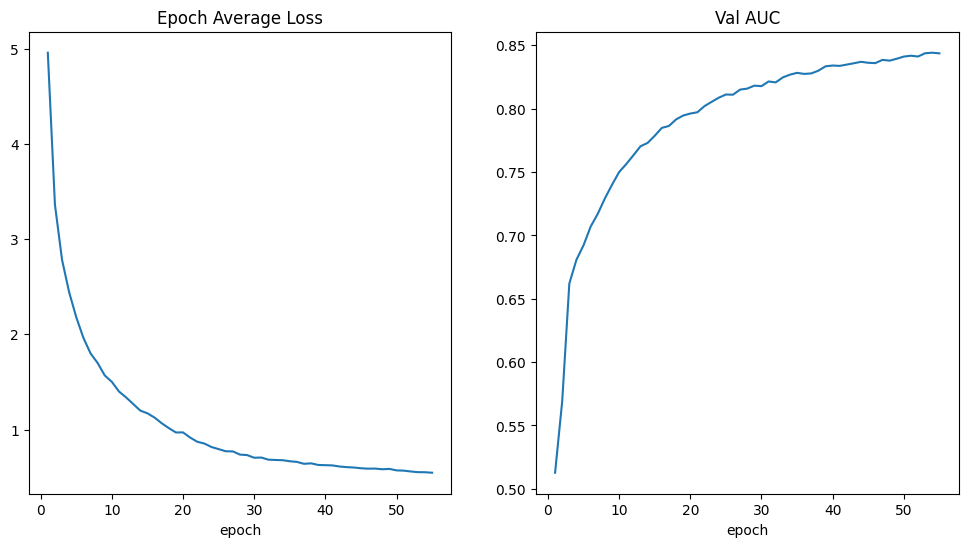

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### 4.1.5. Evaluate the model on test dataset

After training and validation, we've already gotten the best model on the validation test. But we still need to evaluate the model on the test dataset to check whether it's robust and not over-fitting.  

Then we'll use these predictions to generate a classification report.

In [16]:
def eval_model(root_dir):
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    y_pred_logit = []

    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
            outputs = model(test_images)
            probs = y_pred_trans(outputs)
            preds = outputs.argmax(dim=1)
            y_true.extend(test_labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_pred_logit.append(probs.cpu().numpy())


    y_pred_logit = np.concatenate(y_pred_logit)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred, y_pred_logit

y_true, y_pred, y_pred_logit = eval_model(root_dir)

In [17]:
class_names = ['No Finding', 'Pleural Effusion', 'Consolidation']
print(classification_report(y_true, y_pred, target_names = class_names, digits = 4))

                  precision    recall  f1-score   support

      No Finding     0.8424    0.8920    0.8665      2685
Pleural Effusion     0.6725    0.7692    0.7176      1343
   Consolidation     0.3093    0.0670    0.1101       448

        accuracy                         0.7726      4476
       macro avg     0.6081    0.5760    0.5647      4476
    weighted avg     0.7381    0.7726    0.7461      4476



### Plot the precision, recall, thresholds for each class

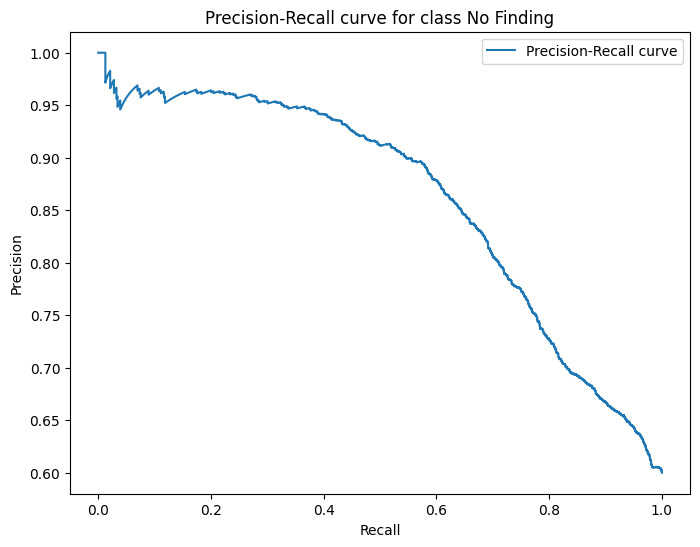

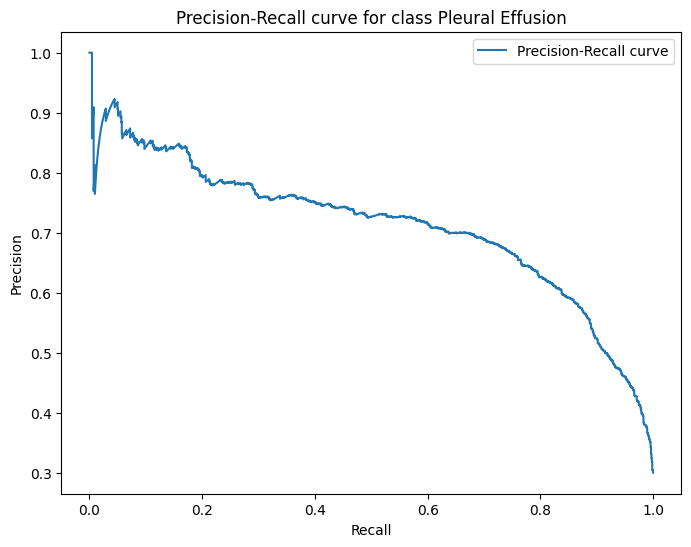

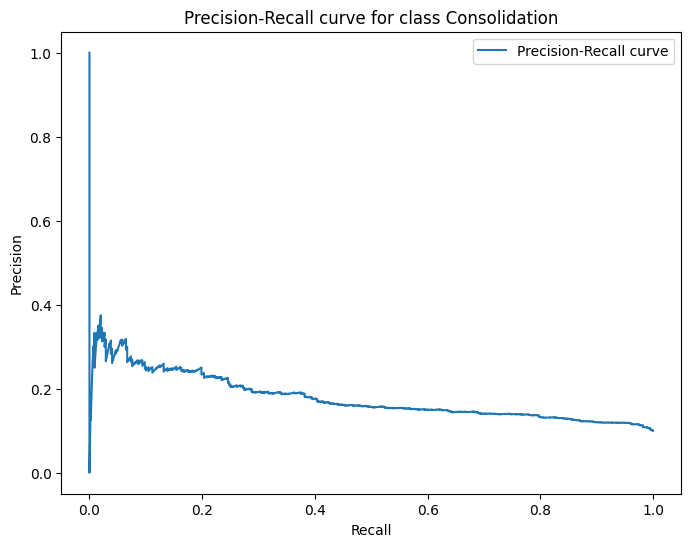

In [18]:
for i in range(len(class_names)):
    precision, recall, thresholds = precision_recall_curve(y_true == i, y_pred_logit[:, i])

    # Plot the precision-recall curve
    plt.figure(figsize = (8, 6))
    plt.plot(recall, precision, label = 'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve for class {}'.format(class_names[i]))
    plt.legend()
    plt.show()

### 4.1.6. Balancing Data for Training

Since the distribution of labels for this dataset is imbalanced, the performance of the underrepresented class may be lower than other classes.
Let's attempt to balance the training dataset within the Dataloader.

Specificlly, we can calculate the percentage of samples for each class in the dataset, and then taking the inverse of these probabilities as weights for each sample that belongs to a specific class. In this way, samples from the underrepresented class are oversampled, and samples from the overrepresented class are subsampled.

In the code block below, create a *WeightedRandomSampler* instance that adopt the resampling weight described above.

In [19]:
from torch.utils.data import WeightedRandomSampler

# counting samples per class
class_counts = np.bincount(train_labels)
print(f"Class counts in training set: {class_counts}")

#calculating weights for each class
class_weights = 1.0 / class_counts
print(f"Class weights: {class_weights}")

# Normalize weights so they sum to 1
class_weights = class_weights / np.sum(class_weights)
print(f"Normalized class weights: {class_weights}")

# Assign weights to each sample based on its class
sample_weights = [class_weights[label] for label in train_labels]

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_labels),
    replacement=True
)

Class counts in training set: [9400 4700 1566]
Class weights: [0.00010638 0.00021277 0.00063857]
Normalized class weights: [0.11107959 0.22215917 0.66676124]


In [20]:
# apply the sampler to training data loader
train_loader = DataLoader(train_ds, batch_size = 50, shuffle = False, num_workers = 10, sampler = sampler)

# re-initialize the model and the optimizer
# Your code below
model = EfficientNetBN(
    model_name="efficientnet-b7",
    spatial_dims=2,
    in_channels=1,
    num_classes=3
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)

### Model training with the resampler

In [21]:
root_dir = "./h2q4_results_resample/"
os.makedirs(root_dir)

best_metric, best_metric_epoch, epoch_loss_values, metric_values = train(root_dir)

Streaming output truncated to the last 5000 lines.
91/313, train_loss: 0.8137
92/313, train_loss: 0.8411
93/313, train_loss: 0.8468
94/313, train_loss: 0.7434
95/313, train_loss: 1.0459
96/313, train_loss: 0.8281
97/313, train_loss: 0.7699
98/313, train_loss: 0.8128
99/313, train_loss: 0.8698
100/313, train_loss: 1.0416
101/313, train_loss: 0.9974
102/313, train_loss: 0.9105
103/313, train_loss: 0.7976
104/313, train_loss: 0.8810
105/313, train_loss: 1.0136
106/313, train_loss: 0.6425
107/313, train_loss: 0.9791
108/313, train_loss: 0.7401
109/313, train_loss: 1.0558
110/313, train_loss: 0.9270
111/313, train_loss: 0.7564
112/313, train_loss: 0.9957
113/313, train_loss: 0.8669
114/313, train_loss: 0.8131
115/313, train_loss: 0.8589
116/313, train_loss: 0.7358
117/313, train_loss: 0.6784
118/313, train_loss: 0.8055
119/313, train_loss: 0.8456
120/313, train_loss: 0.9117
121/313, train_loss: 0.7740
122/313, train_loss: 1.0154
123/313, train_loss: 0.7494
124/313, train_loss: 0.8594
125/31

### Plot the loss and metric

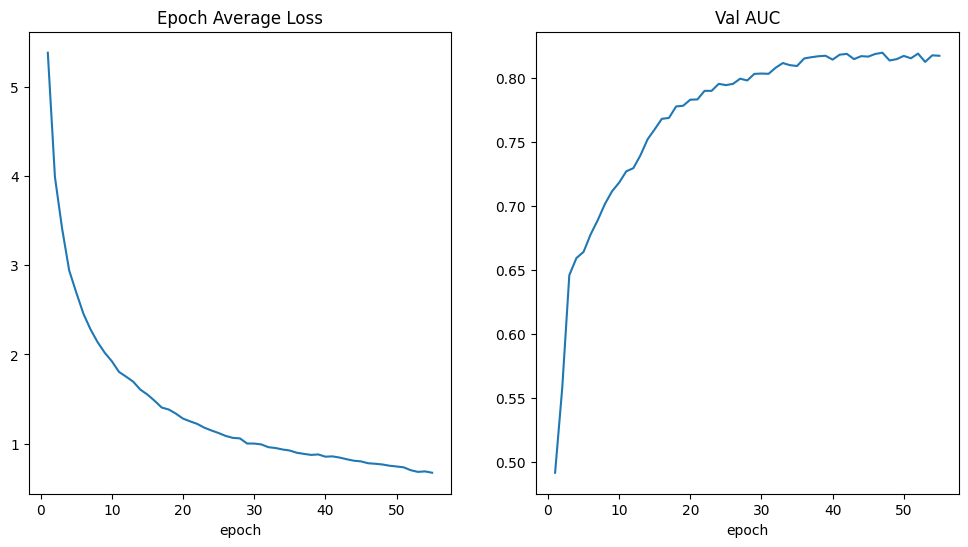

In [22]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [23]:
y_true, y_pred, y_pred_logit = eval_model(root_dir)

In [24]:
class_names = ['No Finding', 'Pleural Effusion', 'Consolidation']
print(classification_report(y_true, y_pred, target_names = class_names, digits = 4))

                  precision    recall  f1-score   support

      No Finding     0.8827    0.7795    0.8279      2685
Pleural Effusion     0.6311    0.6076    0.6191      1343
   Consolidation     0.1897    0.3438    0.2444       448

        accuracy                         0.6843      4476
       macro avg     0.5678    0.5770    0.5638      4476
    weighted avg     0.7379    0.6843    0.7069      4476



### Plot the precision, recall, thresholds for each class

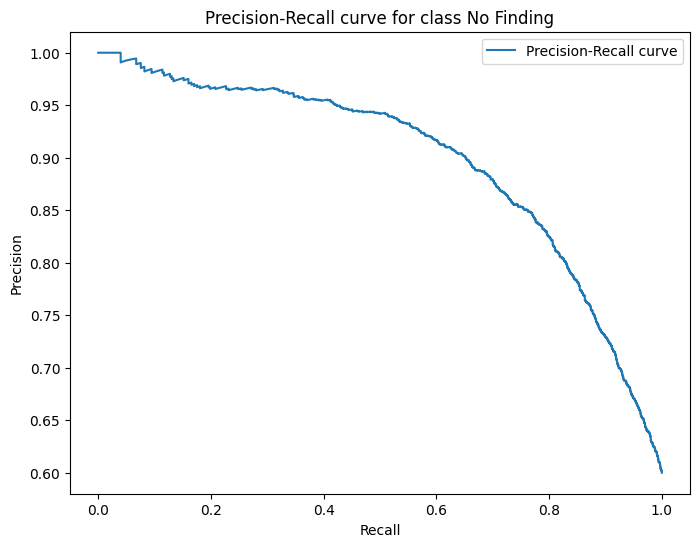

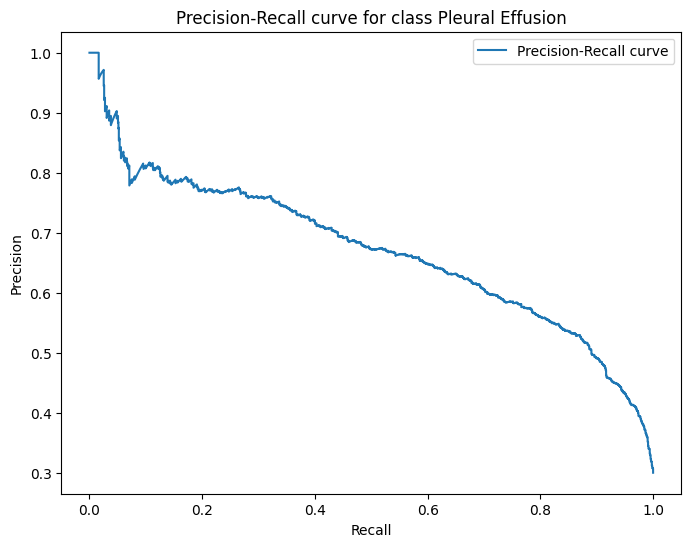

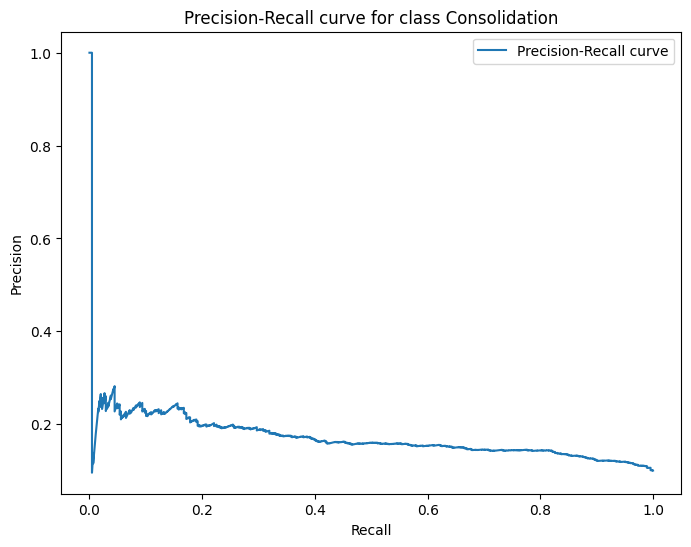

In [25]:
for i in range(len(class_names)):
    precision, recall, thresholds = precision_recall_curve(y_true == i, y_pred_logit[:, i])

    # Plot the precision-recall curve
    plt.figure(figsize = (8, 6))
    plt.plot(recall, precision, label = 'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve for class {}'.format(class_names[i]))
    plt.legend()
    plt.show()

### 4.1.7. Comparison of Results from Balancing vs Not Balancing the Training Dataset within the DataLoader

Please comment on the your findings, comparing the results from balancing vs not balancing the training dataset within the DataLoader, especially on the underrepresented class.

**Comparison:** from the evaluation metrics
1. overall accuracy - The unbalanced model achieves higher overall accuracy, mainly because it sees more instances of the majority class ("No Finding").
2. The unbalanced model performs better in identifying the majority class, as shown by higher recall (89.20%)
3. pleural effusion - suggests that balancing may not always improve performance for moderately underrepresented classes.
4.  Recall and f1-score increases significantly meaning the balanced model correctly identifies more cases of Consolidation.

in my opinion, if the overll accuracy is priority then unbalanced data is preferrable and improving the detection of rare cases is critical balanced data is preferrable.